# Fitting TESS data

In [1]:
import exoplanet as xo

import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits

import os
import warnings
os.environ["MKL_THREADING_LAYER"] = "GNU"
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16}) 

In [2]:
search_result = lk.search_lightcurve('TIC 445859771', author='SPOC')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,445859771,0.0
1,TESS Sector 22,2020,SPOC,120,445859771,0.0
2,TESS Sector 23,2020,SPOC,120,445859771,0.0
3,TESS Sector 48,2022,SPOC,120,445859771,0.0


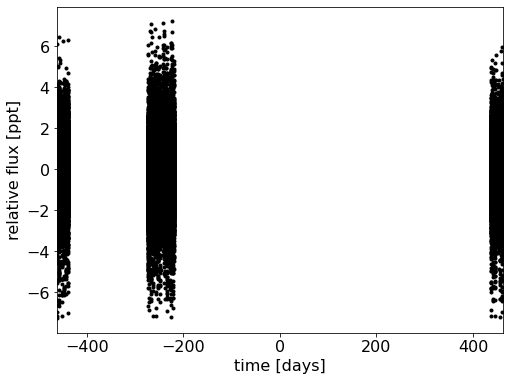

In [3]:
lc_file = lk.search_lightcurve('TIC 445859771', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux


with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

plt.plot(x_, y_, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x_.min(), x_.max())
#plt.savefig('tessdata_1273.png',dpi=200,bbox_inches='tight')

In [4]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(x_, y_, yerr)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)

bls period: 4.631316790471438
bls t0: -461.34256457198444
bls depth: 2.062291019979162
ref_time: 2173.6753273248096
epoch: 1712.3327627528251


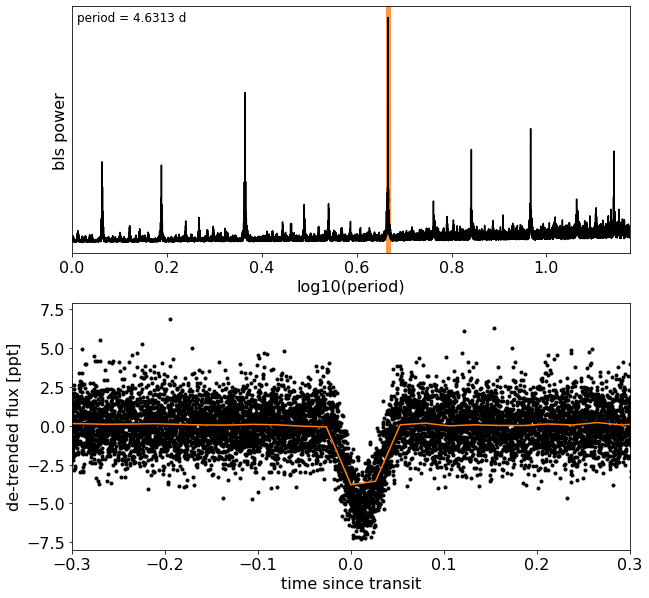

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax.plot(x_fold_, y_, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold_, bins)
num, _ = np.histogram(x_fold_, bins, weights=y_)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")
#plt.savefig('bls_1273.png',dpi=400,bbox_inches='tight')

(-0.3, 0.3)

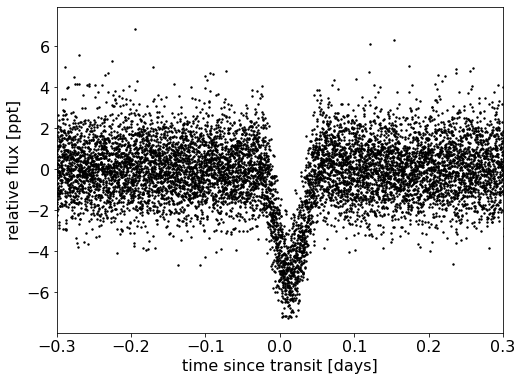

In [6]:
#lc_folded = lc.fold(period = bls_period, epoch_time = bls_t0+ref_time)
#lc_folded.plot(marker='.', markersize=1.5,ls='');
#plt.savefig('toi_1273_tess_data_folded.png',dpi=400,bbox_inches='tight')

x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

plt.scatter(x_fold_, y_, c='k', s=2)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");
plt.xlim(-0.3,0.3)

In [7]:
# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]

## The transit model in PyMC3

In [8]:
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

In [9]:
phase_lc = np.linspace(-0.3, 0.3, 100)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # A parameter describing the observational uncertainties
        logs = pm.Uniform("logs", lower=0, upper=1,
                      testval=np.log(np.std(y)))
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=5.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from Sousa (SOPHIE)
        M_star = 0.98, 0.02
        R_star = 1.07, 0.03

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star[0], sd=M_star[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star[0], sd=R_star[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)
        #El jacobiano de la transf es p_err/p, por tanto al poner un error de 1
        #estamos supoiendo que el error es de 100% del periodo
        period = pm.Deterministic("period", tt.exp(log_period))

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)


        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)


        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
            * 1e3)
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # Finally, this is the likelihoood for the observations
        pm.Normal("obs", mu=light_curve, sd=tt.exp(logs), observed=y[mask])
        
        # Compute and save the phased light curve models
        pm.Deterministic("lc_pred",
            1e3 * star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp)[..., 0],)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[logs])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[logs]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = pmx.eval_in_model(light_curves, map_soln)

    return model, map_soln , extras


model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [logs]


message: Optimization terminated successfully.
logp: -6755.054517248856 -> -6734.401926935112
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -6734.401926935112 -> -6717.605906000946
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -6717.605906000946 -> -6511.795400964384
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -6511.7954009643845 -> -6439.469754323974
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -6439.469754323974 -> -6428.337328522071
optimizing logp for variables: [log_depth]


message: Desired error not necessarily achieved due to precision loss.
logp: -6428.337328522071 -> -6145.938558767417
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -6145.938558767417 -> -6036.096132113562
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -6036.096132113562 -> -6020.838635551384
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -6020.838635551383 -> -6015.960023670535
optimizing logp for variables: [logs]


message: Optimization terminated successfully.
logp: -6015.960023670535 -> -5748.392616217875
optimizing logp for variables: [ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean, logs]


message: Desired error not necessarily achieved due to precision loss.
logp: -5748.392616217876 -> -5042.423728922922


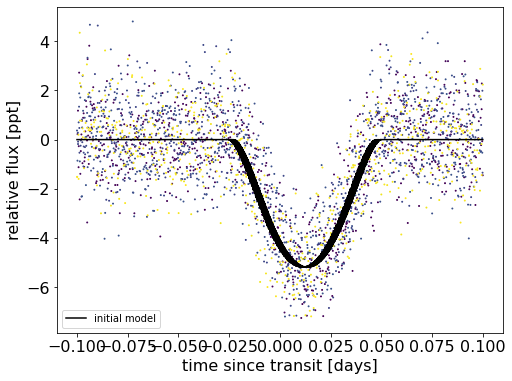

In [10]:
# Plot the data as above
plt.scatter(x_fold, y, c=x, s=0.9)

# Compute the initial transit model evaluated at each data point
# and overplot that
#with model:
#    transit_model = xo.utils.eval_in_model(light_curve)

# For plotting purposes, sort the folded times
inds = np.argsort(x_fold)
plt.plot(x_fold[inds], extras0[inds], "k", label="initial model")
plt.legend(fontsize=10, loc=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");

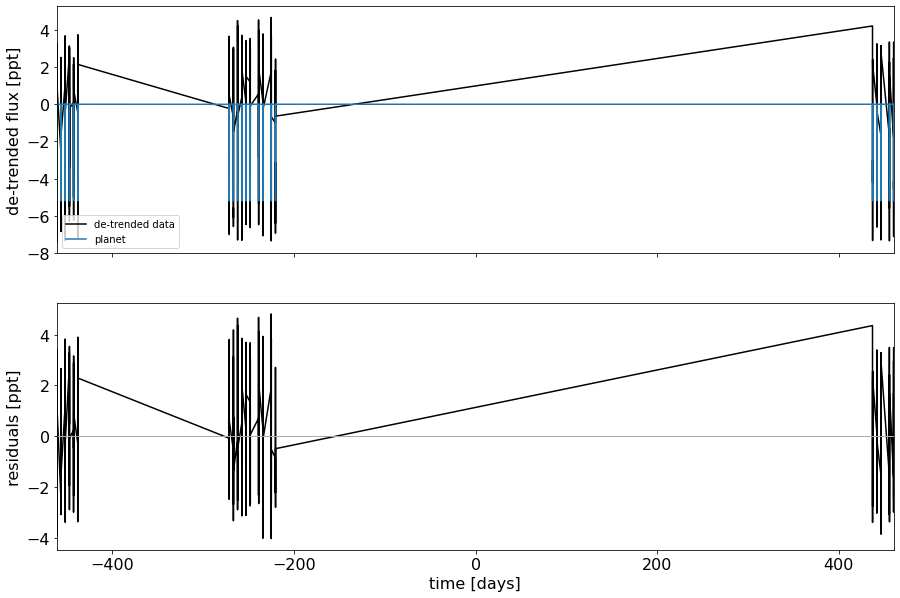

In [11]:
# We plot the initial light curve model:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask] - soln['mean'], "k", label="de-trended data")
    mod = extras
    ax.plot(x[mask], mod, label="planet")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[1]
    mod = np.sum(extras, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    #plt.xlim(-274,-270)
    return fig


_ = plot_light_curve(map_soln0, extras0)

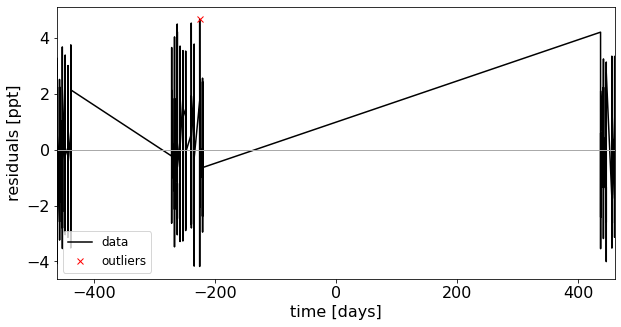

In [12]:
# We can do some sigma clipping to remove significant outliers.
mod = (map_soln0["mean"] + np.sum(extras0, axis=-1))

resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask1 = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask1], resid[~mask1], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())
#plt.xlim(-450,-435)

In [13]:
# And then we re-build the model using the data without outliers.

mask = mask1 

print(mask.sum())
model, map_soln, extras = build_model(mask, map_soln0)

2952


optimizing logp for variables: [logs]


message: Desired error not necessarily achieved due to precision loss.
logp: -5035.072743461309 -> -5035.06193479332
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -5035.06193479332 -> -5035.061934793247
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -5035.061934793247 -> -5035.061934784133
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -5035.061934784136 -> -5035.061934784136
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -5035.061934784133 -> -5035.061934216572
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -5035.061934216572 -> -5035.061934083378
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -5035.061934083378 -> -5035.06193406194
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -5035.0619340619405 -> -5035.061934009016
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -5035.061934009015 -> -5035.059836619769
optimizing logp for variables: [logs]


message: Optimization terminated successfully.
logp: -5035.059836619769 -> -5035.059836617938
optimizing logp for variables: [ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean, logs]


message: Desired error not necessarily achieved due to precision loss.
logp: -5035.059836617938 -> -5035.058718240042


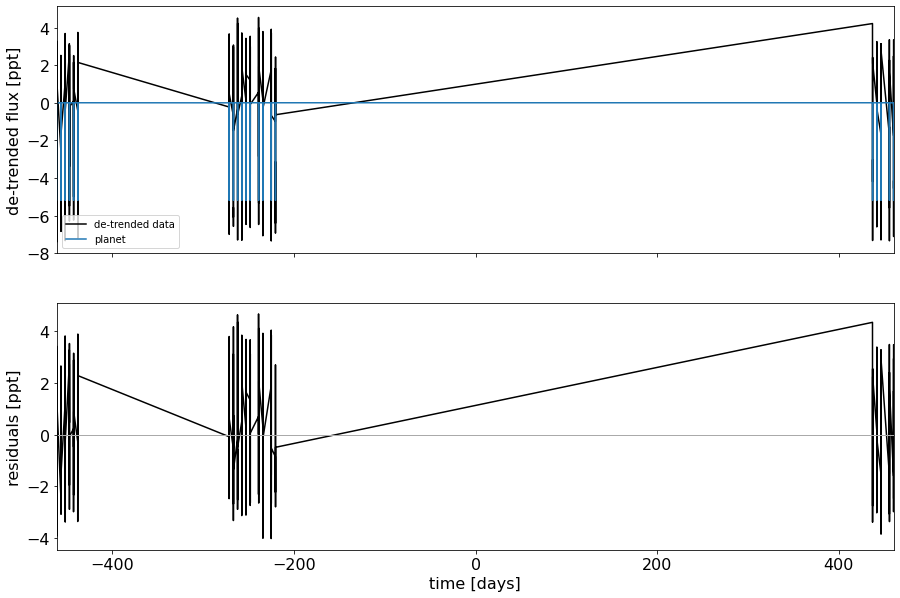

In [14]:
_ = plot_light_curve(map_soln, extras, mask)

In [15]:
# Now that we have the model, we can sample:
with model:
    trace = pmx.sample(
        tune=3500, #1500,
        draws=2000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95, #0.95,
        return_inferencedata=True,
        random_seed=[261136679, 261136680],
        init="adapt_full",
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean, logs]


Sampling 2 chains for 3_500 tune and 2_000 draw iterations (7_000 + 4_000 draws total) took 3453 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [21]:
import arviz as az

az.summary(
    trace,
    var_names=[
        'logs',
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "period",
        "r_star",
        "m_star",
        "u_star",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logs,0.285,0.013,0.260,0.308,0.000,0.000,3566.0,2853.0,1.0
omega,0.191,1.962,-3.141,2.969,0.045,0.047,2308.0,2707.0,1.0
ecc,0.131,0.131,0.000,0.370,0.009,0.009,716.0,236.0,1.0
r_pl,0.118,0.015,0.092,0.145,0.001,0.000,602.0,445.0,1.0
b,0.966,0.024,0.925,1.000,0.001,0.001,589.0,415.0,1.0
t0,-461.329,0.001,-461.331,-461.326,0.000,0.000,478.0,168.0,1.0
period,4.631,0.000,4.631,4.631,0.000,0.000,3468.0,2787.0,1.0
r_star,1.068,0.029,1.016,1.123,0.001,0.000,2940.0,2798.0,1.0
m_star,0.981,0.020,0.941,1.019,0.000,0.000,3486.0,2757.0,1.0
u_star[0],0.731,0.453,0.013,1.496,0.009,0.006,2708.0,2458.0,1.0


In [22]:
radio = trace.posterior["r_pl"].mean().item()*109.076
radio_err = trace.posterior["r_pl"].std().item()*109.076
jitter = np.exp(trace.posterior['logs'].mean().item())
jitter_sigma = np.exp(trace.posterior['logs'].std().item())
periodo = trace.posterior['period'].mean().item()
periodo_sigma = trace.posterior['period'].std().item()
t_0 = trace.posterior['t0'].mean().item()+ref_time
t_0_sigma = trace.posterior['t0'].std().item()
print("Radio = {r:.3f} \u00B1 {r_err:.3f}".format(r=radio, r_err=radio_err))
print("Periodo = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo, p_s=periodo_sigma))
print("Epoca = {e:.5f} \u00B1 {e_s:.4f}".format(e=t_0, e_s=t_0_sigma))
print("Jitter = {J:.3f} \u00B1 {J_s:.3f}".format(J=jitter, J_s=jitter_sigma))

Radio = 12.872 ± 1.634
Periodo = 4.631301 ± 0.000003
Epoca = 1712.34645 ± 0.0015
Jitter = 1.329 ± 1.013


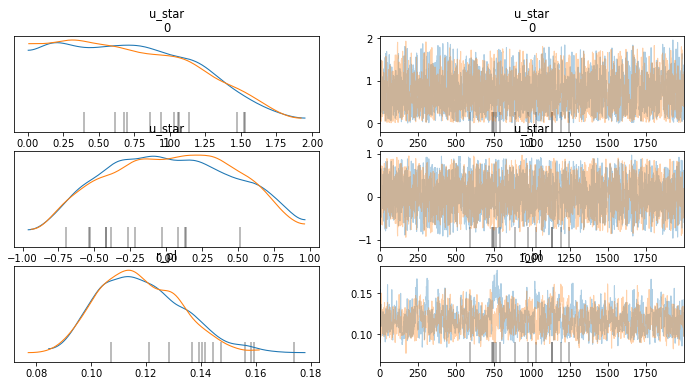

In [23]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag

#_ = az.plot_trace(trace, var_names=['logs', 'omega', 'ecc', 'r_pl', 'b', 't0', 'period'], compact=False)
_ = az.plot_trace(trace, var_names=['u_star', 'r_pl'], compact=False)
#plt.savefig('trace_transit_1273_ustar.png',dpi=200,bbox_inches='tight')

## Results

(-8.0, 5.2)

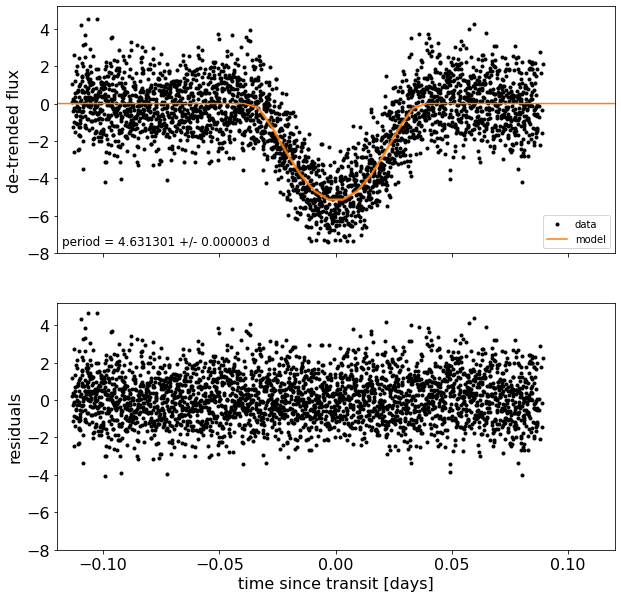

In [24]:
# After sampling, we can make the usual plots.
# First, let's look at the folded light curve plot:

flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# Plot the folded data
ax = axes[0]
x_fold2 = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
ax.plot(x_fold2, y[mask] - map_soln['mean'], ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
#bins = np.linspace(-0.15, 0.15, 30)
#denom, _ = np.histogram(x_fold, bins)
#num, _ = np.histogram(x_fold, bins, weights=y[mask])
#denom[num == 0] = 1.0
#plt.plot(
#    0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned"
#)

# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
ax.plot(phase_lc, pred[1], color="C1", label="model")
art = ax.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.6f} +/- {1:.6f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values))

ax.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

ax.legend(fontsize=10, loc=4)
ax.set_ylabel("de-trended flux")
plt.xlim(-0.12, 0.12)
ax.set_ylim(-8,5.2)

ax = axes[1]
_= ax.plot(x_fold2, y[mask] - np.sum(extras, axis=-1), ".k", label="data", zorder=-1000)
ax.set_ylabel('residuals')
ax.set_xlabel("time since transit [days]")
ax.set_ylim(-8,5.2)
#plt.savefig('fit_transit_1273.png',dpi=400,bbox_inches='tight')

And a corner plot of some of the key parameters:

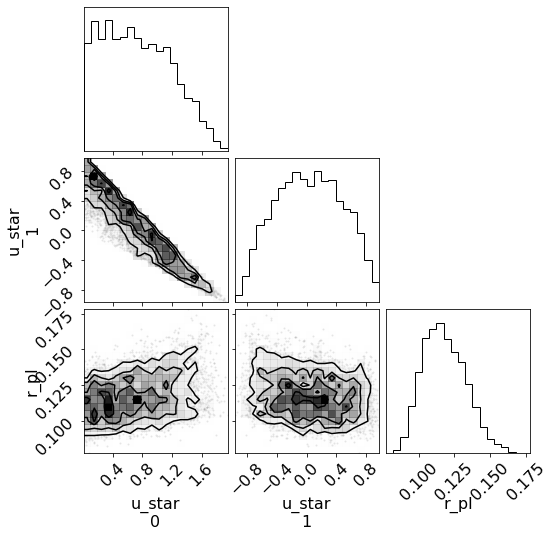

In [25]:
import corner
import astropy.units as u

trace.posterior["r_earth"] = (
    trace.posterior["r_pl"].coords,
    (trace.posterior["r_pl"].values * u.R_sun).to(u.R_earth).value,
)

#_ = corner.corner(trace,
#    var_names=["period", "r_earth", "b", "ecc"],
#    labels=["P [days]", "radius [R_earth]", "b", "ecc", 'u_star'])
_ = corner.corner(trace, var_names=['u_star', 'r_pl'])
#plt.savefig('corner_transit_1273_ustar.png',dpi=200,bbox_inches='tight')